In [80]:
import numpy as np
import pandas as pd
##### imports for LSTM
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [81]:
# cols = ['Compound Sentiment Score','sentiment change','High','Low','Open','Close','Volume','Marketcap','Volatility','date']

# org_df = pd.read_csv('arima_sentiment.csv', usecols=cols)
# org_df.to_csv('sent_price_numerical.csv', header=True, index=False, columns=list(org_df.axes[1]))

In [82]:
org_df = pd.read_csv('sent_price_numerical.csv', parse_dates=['date'])
org_df.set_index('date', inplace=True)

org_df

,Compound Sentiment Score,sentiment change,High,Low,Open,Close,Volume,Marketcap,Volatility
date,,,,,,,,,
2013-04-29,0.45880,-0.10970,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,10.065677
2013-04-30,0.74420,0.28540,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,9.608347
2013-05-01,0.45625,-0.28795,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,29.864461
2013-05-02,0.69350,0.23725,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,36.104697
2013-05-03,0.62490,-0.06860,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,36.697851
...,...,...,...,...,...,...,...,...,...
2021-02-10,0.40190,0.00000,47145.568199,43881.152599,46469.761202,44918.184492,8.730109e+10,8.366169e+11,7.439220
2021-02-11,0.41990,0.01800,48463.467125,44187.762351,44898.711611,47909.331195,8.138891e+10,8.923649e+11,9.676219
2021-02-12,0.40190,-0.01800,48745.733800,46424.977818,47877.034375,47504.851183,7.655504e+10,8.848741e+11,4.998938


# Data scaling

In [83]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# print('dataset.shape', dataset.shape)
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)


Number of features 9


config

In [84]:
expr_name = 'expr_1'
look_back = 60 # 60 days
lstm_layers = 32
epochs=10
batch_size=128

spliting datasets into train and test¶


In [85]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('Close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, pred_col])
    return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  2279
Testing dataset length  570
look_back  60


Build the model and train¶


In [86]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/10
13/13 [==============================] - 3s 53ms/step - loss: 5.3987e-04 - val_loss: 0.0073
Epoch 2/10
13/13 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0047
Epoch 3/10
13/13 [==============================] - 0s 18ms/step - loss: 3.5533e-04 - val_loss: 0.0019
Epoch 4/10
13/13 [==============================] - 0s 18ms/step - loss: 1.4724e-04 - val_loss: 3.3764e-04
Epoch 5/10
13/13 [==============================] - 0s 18ms/step - loss: 8.0767e-05 - val_loss: 3.1440e-04
Epoch 6/10
13/13 [==============================] - 0s 18ms/step - loss: 3.5518e-05 - val_loss: 4.0485e-04
Epoch 7/10
13/13 [==============================] - 0s 19ms/step - loss: 2.9797e-05 - val_loss: 6.7858e-04
Epoch 8/10
13/13 [==============================] - 0s 18ms/step - loss: 4.0225e-05 - val_loss: 6.7294e-04
Epoch 9/10
13/13 [==============================] - 0s 18ms/step - loss: 3.5480e-05 - val_loss: 4.6568e-04
Epoch 10/10
13/13 [==============================] - 

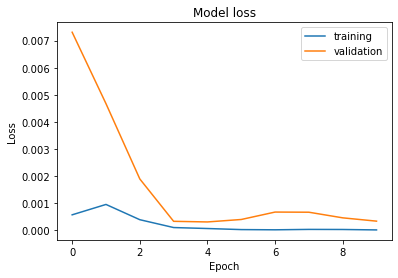

In [87]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [88]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

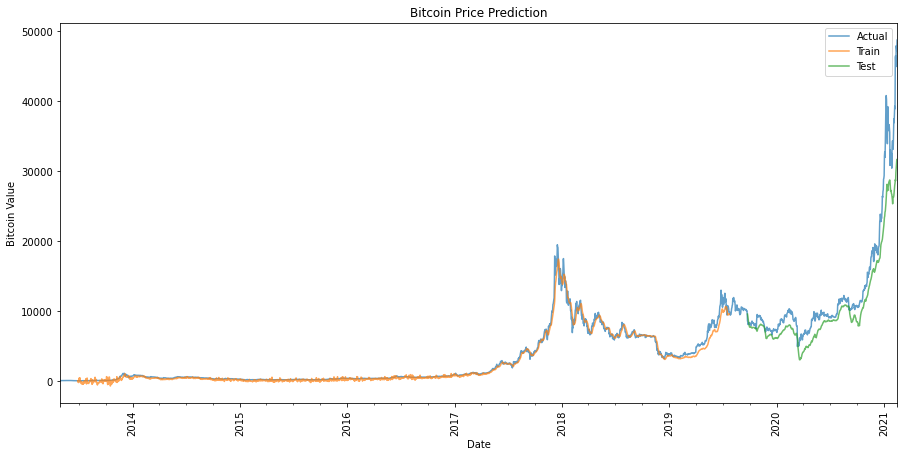

In [89]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(org_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('date',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [90]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_1
--------------------------------------------------
look_back days: 60
lstm_layers: 32
epochs: 10
batch_size: 128
dataset features ['Compound Sentiment Score', 'sentiment change', 'High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap', 'Volatility']
--------------------------------------------------
Train Score: 521.47 RMSE
Test Score: 3578.25 RMSE
--------------------------------------------------
Train Score: 301.81 MAE
Test Score: 2360.81 MAE
--------------------------------------------------
Model summary:
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 5,409
Trainable params: 5,409
Non-trainable p

In [91]:
trainScore_RMSE

521.4730799542667